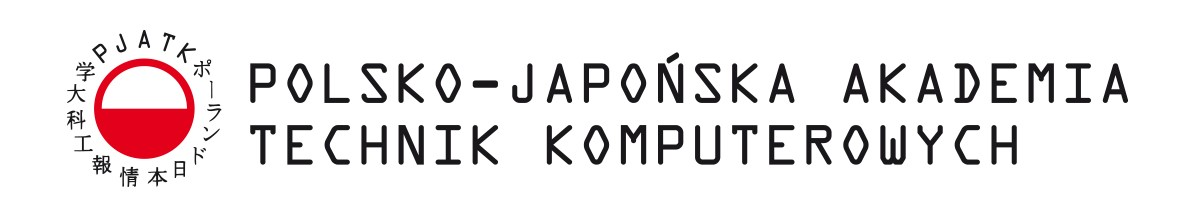


# Uczenie Maszynowe

# Klasyfikacja kwiatów

[Zdjęcia kwiatów](https://we.tl/t-QXhTvcsnHv)

## Przygotujemy sprzęt

#### 1. Podłączamy dysk Google, żeby mieć dostęp do katalogu z kwiatami

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=27ae0244665a080eeaf361fdc97a4fc8cc290f25935b3f4be678a0191ca68dde
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
CPU RAM Free: 12.7 GB  | Proc size: 118.5 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


## Przygotowujemy dane

#### 2. Importujemy potrzebne biblioteki

In [ ]:
import glob
import cv2
from skimage.transform import resize

#### 3. Przeglądamy zdjęcia w folderach i używamy nazw folderów jako etykiet klas kwiatów

In [ ]:
folders = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
X = []
y = []
for folder in folders:
  path = '[twoja ścieżka do folderu z kwiatami]'+folder+'/*.jpg'
  files = glob.glob(path)
  for myFile in files:
    image = cv2.imread(myFile)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = resize(image, (32,32,3))
    X.append(image)
    y.append(folder)

In [ ]:
print(set(y))

#### 4. Dzielimy dane

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
x_train[0]

In [ ]:
import matplotlib.pyplot as plt

img = plt.imshow(x_train[0])

In [ ]:
y_train[0]

'daisy'

**Zamieniamy wszystkie etykiety na dane numeryczne**

- stokrotka [daisy] - 0
- mniszek lekarski [dandelion] - 1
- róża [rose] - 2
- słonecznik [sunflower] - 3
- tulipan [tulip] - 4

In [ ]:
from sklearn.preprocessing import LabelEncoder
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

In [ ]:
print(y_test)

**Zamieniamy etykiety w zbiór 5 liczb, które będą "wejściem" do sieci neuronowej**

In [ ]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

Wyświetlamy sobie wszystkie nowe etykiety

In [ ]:
print(y_test_one_hot)

Print the new label of the first image (the tulip picture).

In [ ]:
print('The one hot label is', y_train_one_hot[0])

#### 5. Normalizujemy pixele w obrazach do wartości w przedziale <0,1> zamiast <0,255>.

In [ ]:
import numpy as np
x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

## Budujemy model sieci neuronowej

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers
model = tf.keras.Sequential()

Dodajemy piewszą warstwę (warstwa konwolucyjna), która wyróżni cechy obrazów i przeniesie je na mapę cech (wymiary 32, 5x5 o nazwie Relu convoluted).
Ponieważ jest to pierwsza warstwa, musimy podać wymiar obrazu - 33 x 32 pixele i głębia 3 (RGB).

In [ ]:
# dodajemy wg. wzoru: model.add(warstwy i nazwa warstwy(parametry), funkcja aktywacji, ew. pozostałe parametry)

Następna warstwa, tzw. 'pooling layer', z filtrem pikseli 2x2 będzie wyróżniać największy element z mapy cech. To doprowadzi do zmniejszenia o połowę rozmiaru mapy (nazywamy ten proces sub samplingiem).

Dodajemy kolejną warstwę konwolucyjną i pooling, ale tym razem nie podajemy wymiarów obrazu.

Dodajemy warstwę, która spłaszczy nam obraz i przerobi na jednowymiarowy wektor, który zostanie następnie przepuszczony przez i połączony z siecią neuronową.

Teraz możemy stworzyć sieć neuronową, w której pierwsza warstwa będzie miała 64 neurony i funkcję aktywacji ReLu.

Ostatnia sieć ma 5 neuronów (każdy odpowiadający jednej klasie) i funkcję aktywacji softmax.


#### Złożona sieć CNN z tych powyższych kroków

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import layers
model = tf.keras.Sequential(
    [
     # dodaj pierwszą warstwę konwolucyjną
     # dodaj warstwę max pooling
     # dodaj kolejną warstwę konwolucyjną
     # dodaj warstwę max pooling
     # dodaj warstwę spłaszczającą obraz na wektor
     # dodaj pierwszą warstwę sieci neuronowej
     # dodaj ostatnią warstwę sieci
    ]
)

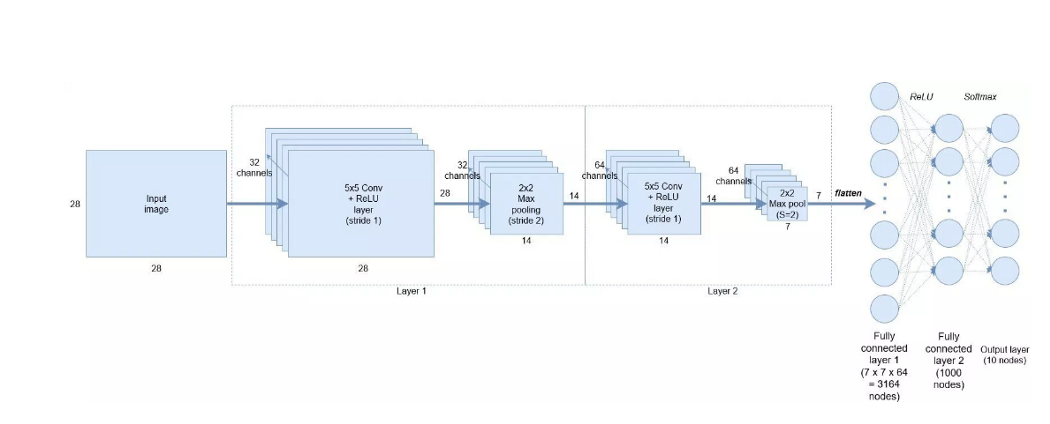

Kompilujemy model. Korzystamy z funkcji kosztu categorical_crossentropy (dla więcej niż 2 klas), optymizera adam, i dokładności do oceny treningu.

In [ ]:
model.compile() # dodać parametry zgodnie z opisem

Rozpoczynamy trening metodą fit(), która znaczy to samo co train. Użyjemy próbek po 25 elementów, 1000 epoch oraz podzielimy dane na treningowe i walidacyjne w stosunku 70-30.

- **Batch**: całkowita liczba próbek treningowych w jednej paczce (części zbioru treningowego).
- **Epoch**: liczba iteracji (powtórzeń), w których cały zbiór treningowy przechodzi przez sieć raz.



In [ ]:
hist = model.fit(x_train, y_train_one_hot,
                 'tu trzeba uzupelnic parametry')

## Robimy ewaluację modelu

In [ ]:
model.evaluate(x_test, y_test_one_hot)[1]

In [ ]:
model.summary()

Kolejnym krokiem jest graficzna reprezentacja modelu i sprawdzenie czy nie dochodzi do przetrenowania.

**Przetrenowanie** następuje na skutek zbytniego dopasowania modelu do danych trenigowych i nieumiejętności przeniesienia modelu na dane ogólne, których wcześniej nie widział.
Można to sprawdzić analizując wykres i sprawdzając stosunek dokładności w zbiorze treningowym i walidacyjnym.

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Testujemy Model

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sunflower.jpg to sunflower.jpg


In [ ]:
new_image = plt.imread("sunflower.jpg")
new_img = plt.imshow(new_image)

Zmieniamy rozmiar

In [ ]:
from skimage.transform import resize
new_image_resized = resize(new_image, (32,32,3))
new_img = plt.imshow(new_image_resized)

In [ ]:
print(new_image_resized)

In [ ]:
prediction = model.predict(np.array([new_image_resized]))
print(prediction)

## Zapisujemy model

In [ ]:
model.save('my_model.fl5')

INFO:tensorflow:Assets written to: my_model.fl5/assets


Aby ponownie wykorzystać model, trzeba go wczytać:

In [ ]:
from keras.models import load_model
model = tf.keras.models.load_model('my_model.fl5')